In [1]:
import pandas as pd
import numpy as np
import string as st
from wordcloud import WordCloud
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline
sns.set(color_codes = True)
import pickle
from sklearn.metrics.pairwise import cosine_similarity
print("Setup Complete")

Setup Complete


## Reading the Data

In [2]:
books = pd.read_csv('../Books.csv',encoding='latin-1',dtype={3:str},low_memory=False)
users = pd.read_csv('../Users.csv',encoding='latin-1')
ratings = pd.read_csv('../Ratings.csv',encoding='latin-1')

In [3]:
print(f"The dimension of Books dataframe is {books.shape}")
print(f"\nThe dimension of users dataframe is {users.shape}")
print(f"\nThe dimension of ratings dataframe is {ratings.shape}")

The dimension of Books dataframe is (271360, 8)

The dimension of users dataframe is (278858, 3)

The dimension of ratings dataframe is (1149780, 3)


## Explore users Data Frame

In [4]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
def is_col_null(dataframe):
    for col in dataframe.columns:
        print(f"The {col} has null values -- {dataframe[col].isnull().any()}")

In [6]:
is_col_null(users)

The User-ID has null values -- False
The Location has null values -- False
The Age has null values -- True


In [7]:
def null_data_perc(dataframe,col):
    print(f"The percentage of null data in {col} is {round(dataframe[col].isnull().sum()*100/dataframe.shape[0],2)} %")

In [8]:
null_data_perc(users,'Age')

The percentage of null data in Age is 39.72 %


### Replace the null values in the column with median age in the column

In [9]:
median_age = users['Age'].median()
users['Age'].fillna(median_age,inplace=True)
null_data_perc(users,"Age")

The percentage of null data in Age is 0.0 %


In [10]:
age_dist = users.groupby('Age')['User-ID'].count().reset_index(name = 'count')
print(f"The range of ages across the user Data Frame is {age_dist['Age'].min()} to {age_dist['Age'].max()}")

The range of ages across the user Data Frame is 0.0 to 244.0


### Book Readers have a general age range of 6-65 years.... source-- "Scholastic Kids & Family Reading Report."

In [11]:
users['Age'].clip(lower=6, upper=65, inplace=True)
age_dist = users.groupby('Age')['User-ID'].count().reset_index(name = 'count')
print(f"The range of ages across the users Data Frame is {age_dist['Age'].min()} to {age_dist['Age'].max()}")

The range of ages across the users Data Frame is 6.0 to 65.0


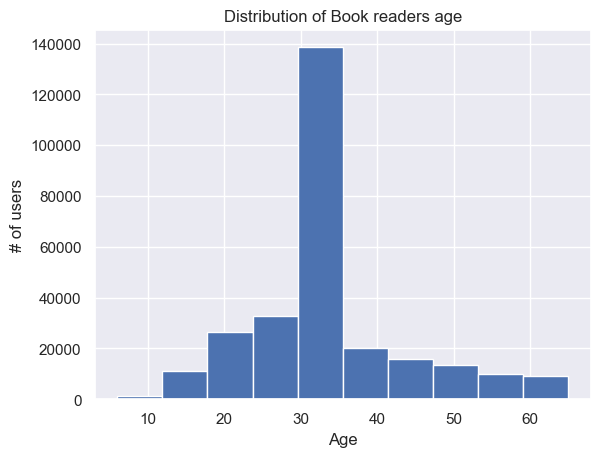

In [12]:
users['Age'].hist(bins=10)
plt.title("Distribution of Book readers age")
plt.xlabel("Age")
plt.ylabel("# of users")
plt.show()

## Extracting Country out of the location of users :- 
1. Find find the location of last occurance of " "
2. Extract the country name which after the last " " till end

In [13]:
users['country'] = users['Location'].apply(lambda x: x.split(',')[-1].strip())
users.head()

,User-ID,Location,Age,country
0,1,"nyc, new york, usa",32.0,usa
1,2,"stockton, california, usa",18.0,usa
2,3,"moscow, yukon territory, russia",32.0,russia
3,4,"porto, v.n.gaia, portugal",17.0,portugal
4,5,"farnborough, hants, united kingdom",32.0,united kingdom


In [14]:
users_ = users[['User-ID','Age','country']]
users_.head()

,User-ID,Age,country
0,1,32.0,usa
1,2,18.0,usa
2,3,32.0,russia
3,4,17.0,portugal
4,5,32.0,united kingdom


In [15]:
top25_country = pd.DataFrame(users_['country'].value_counts()).head(25)

In [16]:
top25_country.head()

,country
usa,139711
canada,21658
united kingdom,18538
germany,17043
spain,13147


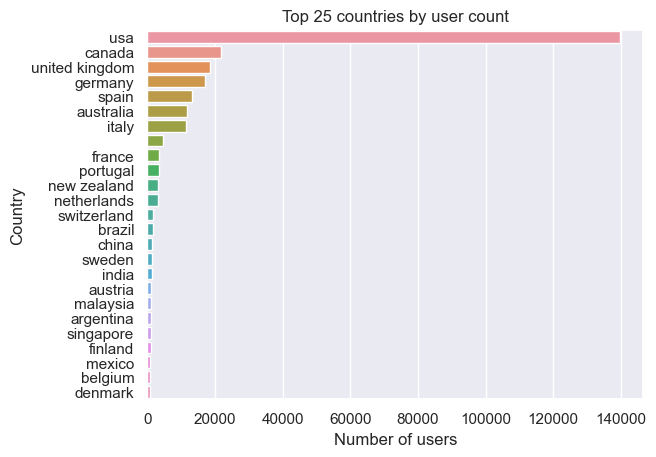

In [17]:
sns.barplot(data = top25_country, y = top25_country.index,x=top25_country['country'],orient='h')
plt.title("Top 25 countries by user count")
plt.ylabel("Country")
plt.xlabel("Number of users")
plt.show()

## Explore books dataframe

In [18]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [19]:
is_col_null(books)

The ISBN has null values -- False
The Book-Title has null values -- False
The Book-Author has null values -- True
The Year-Of-Publication has null values -- False
The Publisher has null values -- True
The Image-URL-S has null values -- False
The Image-URL-M has null values -- False
The Image-URL-L has null values -- True


In [20]:
null_data_perc(books,'Book-Author')

The percentage of null data in Book-Author is 0.0 %


In [21]:
null_data_perc(books,'Publisher')

The percentage of null data in Publisher is 0.0 %


In [22]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

### Null values can be ignored

In [23]:
books_by_auth = books['Book-Author'].value_counts()
century_auth = books_by_auth[books_by_auth > 100]

In [24]:
top_10_auth = century_auth.head(10)

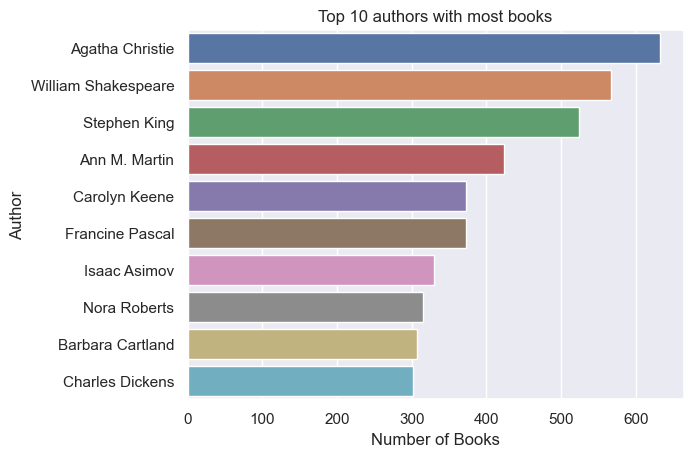

In [25]:
sns.barplot(y = top_10_auth.index, x = top_10_auth.values, orient='h')
plt.title("Top 10 authors with most books")
plt.xlabel("Number of Books")
plt.ylabel("Author")
plt.show()

In [26]:
books_by_publisher = books['Publisher'].value_counts()
popular_publisher = books_by_publisher[books_by_publisher > 2000]

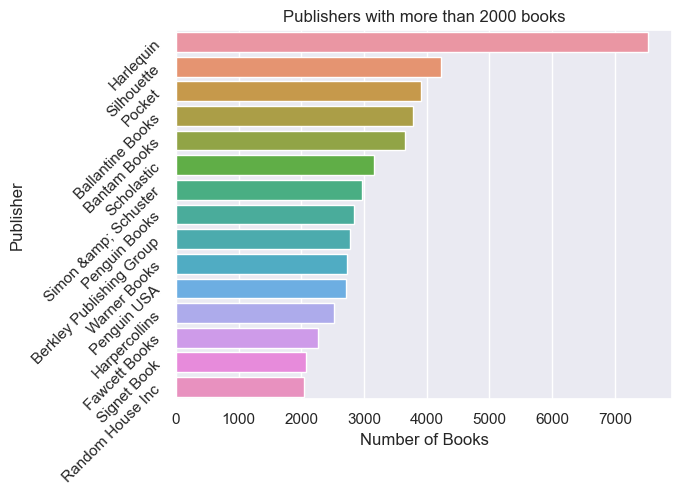

In [27]:
sns.barplot(x=popular_publisher.values, y = popular_publisher.index, orient='h')
plt.title("Publishers with more than 2000 books")
plt.xlabel("Number of Books")
plt.ylabel("Publisher")
plt.yticks(rotation = 45)
plt.show()

In [28]:
general_book_age = books['Year-Of-Publication'].value_counts().head(20)

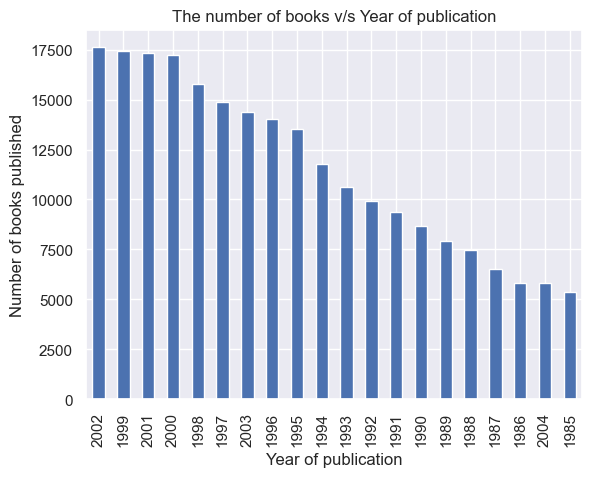

In [29]:
general_book_age.plot(kind = 'bar')
plt.title("The number of books v/s Year of publication")
plt.ylabel("Number of books published")
plt.xlabel("Year of publication")
plt.show()

In [30]:
theme_of_novel = " ".join(books['Book-Title'].astype(str))

In [31]:
theme = WordCloud(width=800, height=400,background_color='white').generate(theme_of_novel)

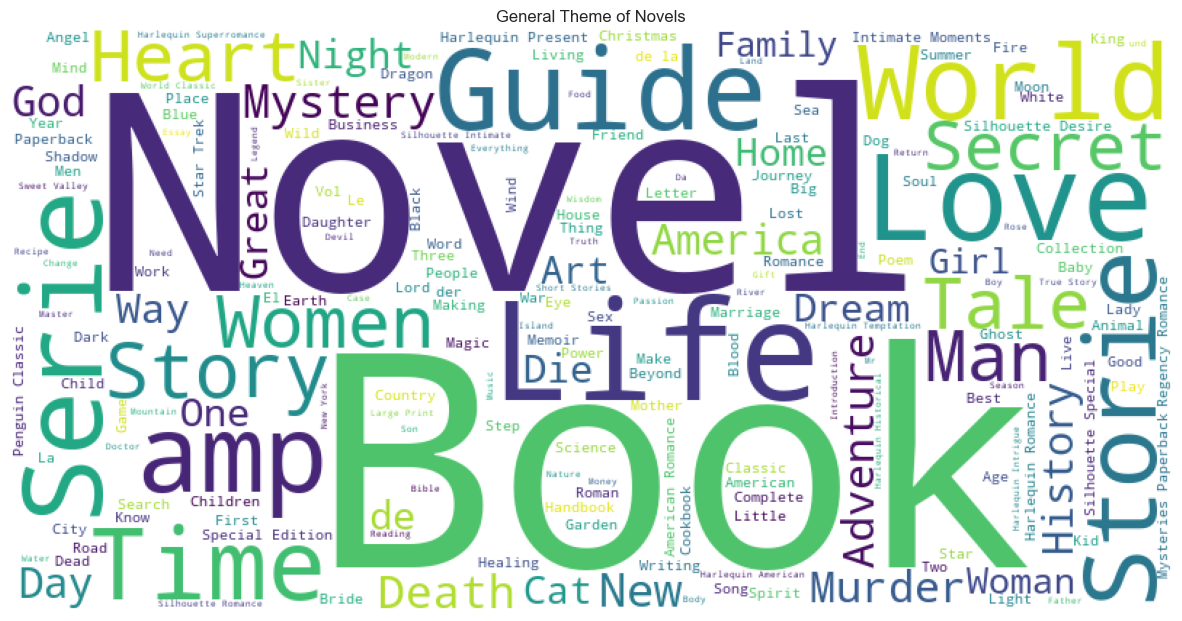

In [32]:
plt.figure(figsize=(15,8))
plt.imshow(theme)
plt.axis('off')
plt.title("General Theme of Novels")
plt.show()

## Explore Ratings Data Frame

In [33]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [34]:
rating_count = ratings['Book-Rating'].value_counts()

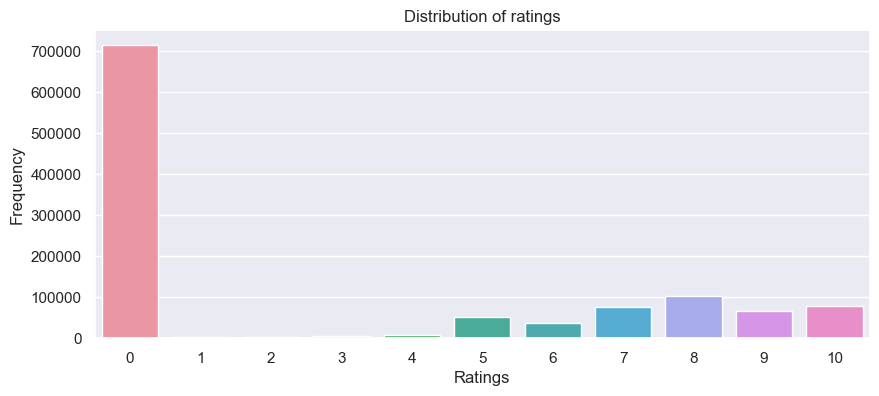

In [35]:
# Plotting distribution of ratings
plt.figure(figsize=(10,4))
sns.countplot(x='Book-Rating',data = ratings)
plt.title("Distribution of ratings")
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.show()

In [36]:
zero_ratings = ratings[ratings['Book-Rating'] == 0].shape[0]
total_ratings = ratings.shape[0]
print(f"The percentage of books with zero ratings are {round(zero_ratings*100/total_ratings,3)} %")

The percentage of books with zero ratings are 62.282 %


In [37]:
ratings['Type'] = ratings['Book-Rating'].apply(lambda x:'Implicit' if x == 0 else 'Explicit')

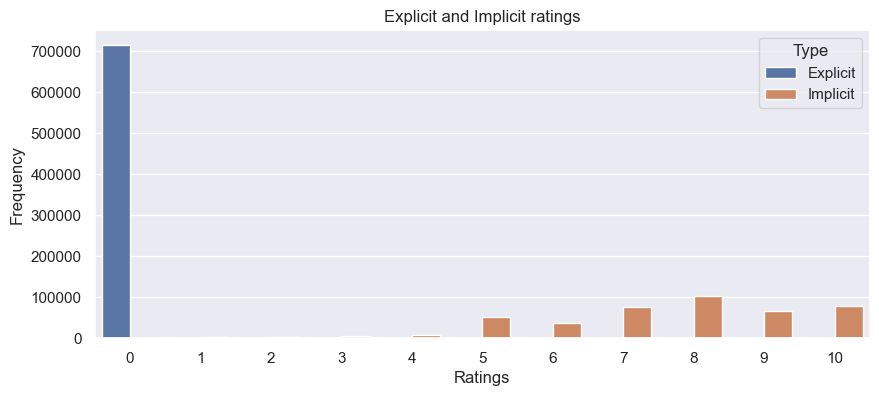

In [38]:
plt.figure(figsize=(10,4))
sns.countplot(x='Book-Rating',data = ratings, hue= 'Type')
plt.title("Explicit and Implicit ratings")
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.legend(title = 'Type',labels = ['Explicit','Implicit'])
plt.show()

## Cleaning Data set

In [39]:
print(f""" Missing values in book data frame ? - \n{books.isnull().any()}\n
\nMissing values in users data frame ? -  \n{users.isnull().any()}\n
\nMissing values in ratings data frame ? -  \n{ratings.isnull().any()}""")

 Missing values in book data frame ? - 
ISBN                   False
Book-Title             False
Book-Author             True
Year-Of-Publication    False
Publisher               True
Image-URL-S            False
Image-URL-M            False
Image-URL-L             True
dtype: bool


Missing values in users data frame ? -  
User-ID     False
Location    False
Age         False
country     False
dtype: bool


Missing values in ratings data frame ? -  
User-ID        False
ISBN           False
Book-Rating    False
Type           False
dtype: bool


## Let's visualize the magnitude of null value lies

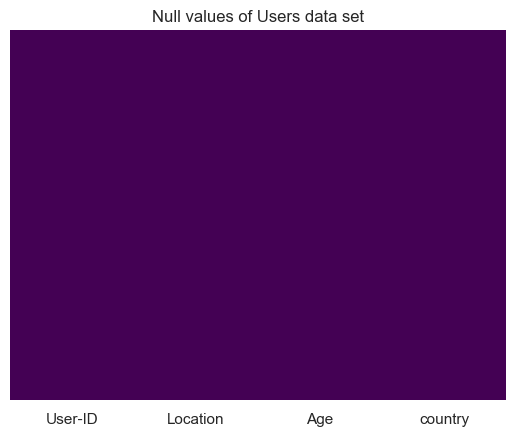

In [40]:
sns.heatmap(users.isnull(), yticklabels = False, cbar = False, cmap= 'viridis')
plt.title("Null values of Users data set")
plt.show()

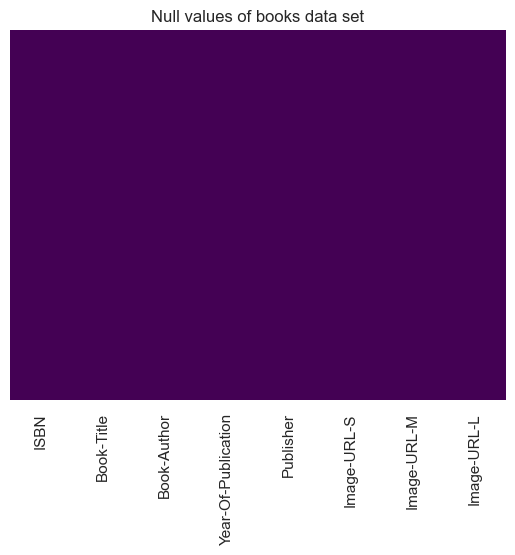

In [41]:
sns.heatmap(books.isnull(), yticklabels = False, cbar = False, cmap= 'viridis')
plt.title("Null values of books data set")
plt.show()

1. The null value in user Data Frame lies Age column and is very high number hence will have to drop the column
2. Even though null values are present in two columns of book data set there occurance seem very very low (droping individual values won't make any difference)

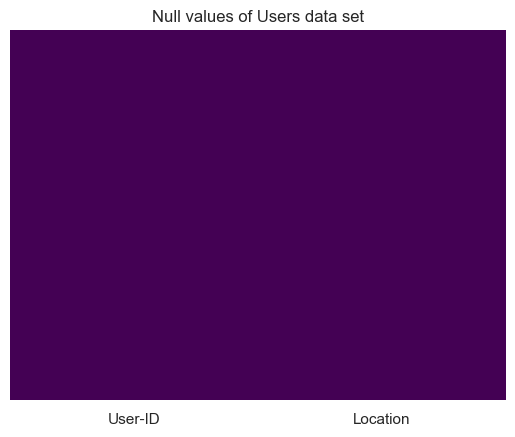

In [41]:
users = users[['User-ID','Location']]
sns.heatmap(users.isnull(), yticklabels = False, cbar = False, cmap= 'viridis')
plt.title("Null values of Users data set")
plt.show()

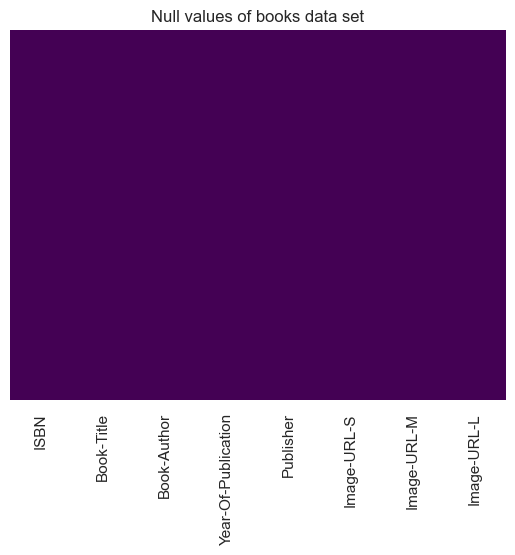

In [42]:
books.dropna(inplace=True)
sns.heatmap(books.isnull(), yticklabels = False, cbar = False, cmap= 'viridis')
plt.title("Null values of books data set")
plt.show()

## Duplicate values -- No Duplicate values in any data frame

In [43]:
books[books.duplicated()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


In [44]:
users[users.duplicated()]

,User-ID,Location


In [45]:
ratings[ratings.duplicated()]

,User-ID,ISBN,Book-Rating,Type


## No Duplicates in any Data frame

### Merging the data Frames

In [46]:
df = books.merge(ratings, on ='ISBN')[['Book-Title','Book-Author','Year-Of-Publication','Publisher','Image-URL-M','User-ID','Book-Rating']]
df.head()

,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M,User-ID,Book-Rating
0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,2,0
1,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,8,5
2,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,41385,0


In [47]:
df1 = df.merge(users,on='User-ID')[['Book-Title','Book-Author','Year-Of-Publication','Publisher','Image-URL-M','User-ID','Book-Rating','Location']]
df1.head()

,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M,User-ID,Book-Rating,Location
0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa"
1,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada"
2,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,8,0,"timmins, ontario, canada"
3,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,8,0,"timmins, ontario, canada"
4,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,8,0,"timmins, ontario, canada"


In [48]:
df1.shape

(1031129, 8)

In [49]:
df1.isnull().sum()

Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-M            0
User-ID                0
Book-Rating            0
Location               0
dtype: int64

## Getting into more depth -- Finding the unique value all the columns

In [50]:
for feature in df1.columns:
    uniq = np.unique(df1[f'{feature}'])
    print(f"{feature} : {len(uniq)} distinct values\n")

Book-Title : 241066 distinct values

Book-Author : 101585 distinct values

Year-Of-Publication : 116 distinct values

Publisher : 16725 distinct values

Image-URL-M : 269836 distinct values

User-ID : 92106 distinct values

Book-Rating : 11 distinct values

Location : 22480 distinct values



## Model Building :- 

1. Popularity Based model

### The popularity-based recommendation system suggests books based on their overall popularity and average ratings. We will display the top 100 books with a minimum of 300 ratings.

In [51]:
num_ratings_df = df.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_ratings_df.rename(columns = {'Book-Rating':'num_ratings'}, inplace=True)

In [52]:
avg_rating = df.groupby('Book-Title').mean(numeric_only = True)['Book-Rating'].reset_index()
avg_rating.rename(columns = {'Book-Rating':'avg_ratings'}, inplace=True)

In [53]:
avg_rating.head()

,Book-Title,avg_ratings
0,A Light in the Storm: The Civil War Diary of ...,2.25
1,Always Have Popsicles,0.00
2,Apple Magic (The Collector's series),0.00
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.00
4,Beyond IBM: Leadership Marketing and Finance ...,0.00


In [54]:
books_ratings_num = num_ratings_df.merge(avg_rating,on='Book-Title')
popular_book_df = books_ratings_num[num_ratings_df['num_ratings'] >= 300].sort_values('avg_ratings', ascending = False).reset_index().drop(columns = 'index').head(100)

In [55]:
# Selecting relevent columns for recommendation 
popular_book_df.merge(df, on='Book-Title').drop_duplicates('Book-Title')[['Book-Title','Book-Author', 'Publisher', 'Image-URL-M', 'num_ratings', 'avg_ratings']].reset_index().drop(columns = 'index')

,Book-Title,Book-Author,Publisher,Image-URL-M,num_ratings,avg_ratings
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,Scholastic,http://images.amazon.com/images/P/0439136350.0...,428,5.852804
1,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,Scholastic,http://images.amazon.com/images/P/0439139597.0...,387,5.824289
2,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,Scholastic,http://images.amazon.com/images/P/043935806X.0...,347,5.501441
3,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,Scholastic,http://images.amazon.com/images/P/0439064872.0...,556,5.183453
4,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. TOLKIEN,Del Rey,http://images.amazon.com/images/P/0345339703.0...,368,4.948370
...,...,...,...,...,...,...
95,The Cider House Rules,John Irving,Bantam Books,http://images.amazon.com/images/P/0553258001.0...,393,2.969466
96,The Alienist,Caleb Carr,Bantam Books,http://images.amazon.com/images/P/0553572997.0...,350,2.965714
97,Violets Are Blue,James Patterson,Warner Vision,http://images.amazon.com/images/P/0446611212.0...,379,2.955145
98,The Rainmaker,JOHN GRISHAM,Dell,http://images.amazon.com/images/P/044022165X.0...,501,2.922156


In [56]:
first_page_recommendation = popular_book_df.merge(df, on='Book-Title').drop_duplicates('Book-Title')[['Book-Title','Book-Author', 'Publisher', 'Image-URL-M', 'num_ratings', 'avg_ratings']].reset_index().drop(columns = 'index')
pickle.dump(first_page_recommendation,open('Popular_recommendation.pkl','wb'))

## Collaberative Filltering-based recommendation 

* Collaborative filtering analyzes user interactions and recommends books based on user behavior patterns. Here, we consider users rated minimum 250 books and books with ratings from at least 50 users.

In [57]:
user250 = df1.groupby('User-ID').count()['Book-Rating'] > 250
users_250_ratings = user250[user250].index

In [58]:
filtered_users_rating = df1[df1['User-ID'].isin(users_250_ratings)]
filtered_users_rating.shape

(429533, 8)

In [59]:
x = filtered_users_rating.groupby('Book-Title').count()['User-ID'] > 50
famuos_books = x[x].index

In [60]:
final_book_db = filtered_users_rating[filtered_users_rating['Book-Title'].isin(famuos_books)]
final_book_db.shape

(43993, 8)

In [61]:
final_book_db.head(2)

,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M,User-ID,Book-Rating,Location
81,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,11676,9,"n/a, n/a, n/a"
84,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,11676,9,"n/a, n/a, n/a"


+ make pivot table for collabrative filtering
+ genrate similarity score based on cosine similarity

In [62]:
pivot_table = final_book_db.pivot_table(index='Book-Title',columns='User-ID',values = 'Book-Rating')
pivot_table.fillna(0,inplace=True)

In [63]:
similarity_scores = cosine_similarity(pivot_table)
similarity_scores

array([[1.        , 0.12637786, 0.01584756, ..., 0.1387288 , 0.08450515,
        0.0521102 ],
       [0.12637786, 1.        , 0.28824811, ..., 0.08010424, 0.18117097,
        0.1617243 ],
       [0.01584756, 0.28824811, 1.        , ..., 0.05165773, 0.05618509,
        0.12893887],
       ...,
       [0.1387288 , 0.08010424, 0.05165773, ..., 1.        , 0.07113412,
        0.02067643],
       [0.08450515, 0.18117097, 0.05618509, ..., 0.07113412, 1.        ,
        0.11219793],
       [0.0521102 , 0.1617243 , 0.12893887, ..., 0.02067643, 0.11219793,
        1.        ]])

In [64]:
similarity_scores.shape

(552, 552)

## Function to recommend similar book

In [71]:
def recommend(book_name = None):
    if book_name == None:
        book_name = random.choice(popular_book_df['Book-Title'])
    index = np.where(np.array(list(pivot_table.index)) == book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])), reverse=True, key=lambda x: x[1])[1:6]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = books[books['Book-Title'] == pivot_table.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
        data.append(item)
    return data

In [85]:
recommend()

[['Harry Potter and the Goblet of Fire (Book 4)',
  'J. K. Rowling',
  'http://images.amazon.com/images/P/0439139597.01.MZZZZZZZ.jpg'],
 ['Harry Potter and the Prisoner of Azkaban (Book 3)',
  'J. K. Rowling',
  'http://images.amazon.com/images/P/0439136350.01.MZZZZZZZ.jpg'],
 ['Harry Potter and the Chamber of Secrets (Book 2)',
  'J. K. Rowling',
  'http://images.amazon.com/images/P/0439064872.01.MZZZZZZZ.jpg'],
 ["Harry Potter and the Sorcerer's Stone (Book 1)",
  'J. K. Rowling',
  'http://images.amazon.com/images/P/0590353403.01.MZZZZZZZ.jpg'],
 ["Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
  'J. K. Rowling',
  'http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg']]

In [77]:
# Save collaborative filtering files in into pickle files
pickle.dump(pivot_table, open('pt.pkl', 'wb'))
pickle.dump(books,open('books.pkl','wb'))
pickle.dump(similarity_scores,open('similarity_scores.pkl','wb'))